In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from Bspline.BsplineLie import BsplineLie
import manifpy as lie
import random
from Models.RobotModel import RobotDynamicsModel


# Ensure matplotlib inline mode for Jupyter
%matplotlib inline

In [2]:
file_paths = ["Data/Mujoco_less_friction_track_mppi.csv",
              "Data/Mujoco_less_friction_track_mppi2.csv",
              "Data/Mujoco_less_friction_track_manual.csv",
              "Data/Mujoco_less_friction_track_manual2.csv",
              "Data/Mujoco_less_friction_track_manual3.csv",
              "Data/Mujoco_less_friction_track_manual4.csv",
              "Data/Mujoco_less_friction_track_manual5.csv",
              "Data/Mujoco_less_friction_track_manual6.csv",
              "Data/Mujoco_less_friction_track_NNmppi.csv",
              "Data/Mujoco_less_friction_track_NNmppi2.csv",
              "Data/Mujoco_less_friction_track_NNmppi3.csv",
              "Data/Mujoco_less_friction_random.csv",
              "Data/Mujoco_less_friction_random2.csv",
              "Data/Mujoco_less_friction_random3.csv",
              "Data/Mujoco_less_friction_random4.csv",
              "Data/Mujoco_less_friction_random5.csv"]

# file_paths = ["Data/Mujoco_less_friction_track_manual.csv", "Data/Mujoco_less_friction_track_manual2.csv", "Data/Mujoco_less_friction_track_manual3.csv", "Data/Mujoco_less_friction_track_manual4.csv", "Data/Mujoco_less_friction_track_manual5.csv", "Data/Mujoco_less_friction_track_manual6.csv"]
# file_paths = ["Data/Mujoco_less_friction_track_mppi.csv", "Data/Mujoco_less_friction_track_mppi2.csv"]

In [3]:
def plot_path(states):
    x = states[:,0]
    y = states[:,1]
    yaw = states[:, 2]
    # Create a figure for the plot
    plt.figure(figsize=(10, 10))

    # Plot the robot's trajectory
    plt.plot(x, y, label="Trajectory")

    # Add quiver plot to show yaw at different points
    skip = 2  # Plot yaw every 'skip' points to avoid clutter
    plt.quiver(x[::skip], y[::skip], np.cos(yaw[::skip]), np.sin(yaw[::skip]), 
            color='r', scale=50, label="Yaw")

    # Add labels and title
    plt.xlabel("X position")
    plt.ylabel("Y position")
    plt.title("Robot Pose (Trajectory and Yaw)")
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.axis('equal')  # Ensure equal scaling for both axes
    plt.show()

In [4]:
import sophuspy as sp
def pi2pi(angle):
    """
    Normalize angle to [-π, π] range using modulo operation.
    
    Args:
        angle (float): Input angle in radians
    
    Returns:
        float: Normalized angle in radians between -π and π
    """
    return ((angle + np.pi) % (2 * np.pi)) - np.pi

def rotation_matrix_SO2(yaw):
    return np.array([[np.cos(yaw), - np.sin(yaw)], [np.sin(yaw), np.cos(yaw)]])
    
# Assume sophuspy provides SE2 for pose manipulation and log/exp mapping
def apply_relative_transformation(states):
    """Transform all states with respect to the last pose using SE(2) log and exp."""
    transformed_states = []
    
    pivot_pose = sp.SE2(rotation_matrix_SO2(states[-2, 2]), states[-2, 0:2])
    
    # Transform each pose relative to the last one
    for x, y, yaw in states:
        current_pose = sp.SE2(rotation_matrix_SO2(yaw), np.array([x, y]))
        relative_pose = pivot_pose.inverse() * current_pose  # relative transformation
        # print(relative_pose.log())
        transformed_states.append( (relative_pose).log())
    return transformed_states

def apply_simple_deletion_transformation(states):
    transformed_states = []
    pivot_pose = states[-2]
    for i in range(len(states)):
        transformed_states.append(states[i] - pivot_pose)
    return transformed_states


In [5]:
# Constants
h = 20  # history length
batch_size = 500 # Define batch size for DataLoader
train_val_split_ratio = 0.8  # 80% train, 20% validation
state_columns = ['x', 'y', 'yaw']
states_dof = len(state_columns)  # x, y, yaw
# Prepare the data
action_columns = ['accel', 'steer']

# Create sequences with history length h
input_sequences = []
output_sequences = []
tot_duration = 0
num_of_augmentation = 1
# file_paths = ["Data/Mujoco_less_friction_track_mppi.csv"]
for file_path in file_paths:
    path_data = pd.read_csv(file_path)

    # Display the first few rows
    path_data.head()
    times = np.array(path_data["timestamp"])
    dataset_duration = times[-1] - times[0]
    tot_duration += dataset_duration
    print(f"{file_path} is {dataset_duration/60}m")
    states = path_data[state_columns].values
    actions = path_data[action_columns].values
    # plot_path(states)
    # cnt = 0
    for _ in range(num_of_augmentation):
        # plot_path(augmented_states)
        for i in range(len(states) - h - 20 * 30):
            # Original sequence
            if times[i+h] - times[i+h - 1] > 1/18:
                # cnt+=1
                continue
            # plot_path(states[i:i + h + 1])

            transformed_state = apply_simple_deletion_transformation(states[i:i + h + 1])
            # plot_path(np.array(transformed_state))
            input_seq = np.concatenate((transformed_state[:h], actions[i:i + h]), axis=1).flatten()
            output_seq = transformed_state[h]
            input_sequences.append(input_seq)
            output_sequences.append(output_seq)
    # break
    # print(len(times) -  cnt)
print(f"Total duration is {tot_duration/60}m")


Data/Mujoco_less_friction_track_mppi.csv is 2.549986430009206m
Data/Mujoco_less_friction_track_mppi2.csv is 63.17984869082769m
Data/Mujoco_less_friction_track_manual.csv is 4.868333295981089m
Data/Mujoco_less_friction_track_manual2.csv is 10.501390854517618m
Data/Mujoco_less_friction_track_manual3.csv is 12.43201783100764m
Data/Mujoco_less_friction_track_manual4.csv is 2.6356539885203043m
Data/Mujoco_less_friction_track_manual5.csv is 0.6723843693733216m
Data/Mujoco_less_friction_track_manual6.csv is 3.0358337203661603m
Data/Mujoco_less_friction_track_NNmppi.csv is 2.3366767168045044m
Data/Mujoco_less_friction_track_NNmppi2.csv is 3.5230408986409505m
Data/Mujoco_less_friction_track_NNmppi3.csv is 6.784117464224497m
Data/Mujoco_less_friction_random.csv is 9.225876994927724m
Data/Mujoco_less_friction_random2.csv is 5.978924159208933m
Data/Mujoco_less_friction_random3.csv is 165.18927686214448m
Data/Mujoco_less_friction_random4.csv is 29.593201434612276m
Data/Mujoco_less_friction_random5.

In [6]:
# Convert to NumPy arrays and then to PyTorch tensors
input_sequences = np.array(input_sequences)
output_sequences = np.array(output_sequences)

# Convert to PyTorch tensors
inputs = torch.tensor(input_sequences, dtype=torch.float32)
outputs = torch.tensor(output_sequences, dtype=torch.float32)
# Check shapes
print(inputs.shape, outputs.shape)  # (samples, h * (|x| + |a|)), (samples, |x|)

# Dataset and DataLoader Setup
dataset = TensorDataset(inputs, outputs)

# Split dataset into train, validation, and test sets (80-10-10 split)
train_size = int(len(dataset) * train_val_split_ratio)
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

torch.Size([268540, 100]) torch.Size([268540, 3])


In [7]:

# Instantiate the model
input_size = h * (len(state_columns) + len(action_columns))  # h * (|x| + |a|)
model = RobotDynamicsModel(input_size, len(state_columns))
model

RobotDynamicsModel(
  (fc1): Linear(in_features=100, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=600, bias=True)
  (fc4): Linear(in_features=600, out_features=200, bias=True)
  (output_layer): Linear(in_features=200, out_features=3, bias=True)
)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the evaluate function to calculate loss on validation/test sets
def evaluate(loader):
    model.eval()  # Set model to evaluation mode
    total_loss, total_samples = 0, 0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, targets)
            total_loss += loss.item() * len(targets)
            total_samples += len(targets)

    return total_loss / total_samples  # Return average loss

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
print(f"Training w {device}")
# Training loop with validation
best_val_loss = float('inf')  # Initialize best validation loss to infinity
train_losses, val_losses = [], []
epochs = 100
last_saved_epoch = - 10
for epoch in range(epochs):
    model.train()  # Set model to training mode

    train_loss = 0  # Accumulate training loss
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        optimizer.zero_grad()  # Clear previous gradients
        predictions = model(inputs)
        loss = criterion(predictions, targets)  # Compute loss

        # Backward pass and optimization
        loss.backward()  # Backpropagate gradients
        optimizer.step()  # Update model parameters

        train_loss += loss.item() * len(targets)  # Accumulate loss

    # Calculate average train loss for the epoch
    train_loss /= len(train_set)

    # Evaluate on validation set
    val_loss = evaluate(val_loader)
    # Track losses per epoch
    if val_loss < 10 and train_loss < 10:
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    # Save the best model based on validation loss
    if val_loss < best_val_loss and epoch - last_saved_epoch > 10:
        last_saved_epoch = epoch
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Mujoco_model.pth')
        print(f"Saved Best Model at Epoch {epoch + 1} with Validation Loss: {val_loss:.4f}")

    # Print progress every 1000 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Evaluate on the test set after training completes
test_loss = evaluate(test_loader)
print(f'Test Loss: {test_loss:.4f}')

Training w cuda
Saved Best Model at Epoch 2 with Validation Loss: 0.0629
Epoch [10/100], Train Loss: 0.0522, Val Loss: 0.0573
Saved Best Model at Epoch 13 with Validation Loss: 0.0563
Epoch [20/100], Train Loss: 0.0320, Val Loss: 0.0566
Epoch [30/100], Train Loss: 0.0217, Val Loss: 0.0615
Epoch [40/100], Train Loss: 0.0168, Val Loss: 0.0583
Epoch [50/100], Train Loss: 0.0148, Val Loss: 0.0609
Epoch [60/100], Train Loss: 0.0115, Val Loss: 0.0615
Saved Best Model at Epoch 65 with Validation Loss: 0.0560
Epoch [70/100], Train Loss: 0.0104, Val Loss: 0.0561
Saved Best Model at Epoch 78 with Validation Loss: 0.0549
Epoch [80/100], Train Loss: 0.0087, Val Loss: 0.0574
Epoch [90/100], Train Loss: 0.0078, Val Loss: 0.0596
Saved Best Model at Epoch 98 with Validation Loss: 0.0545
Epoch [100/100], Train Loss: 0.0072, Val Loss: 0.0652
Test Loss: 0.0600


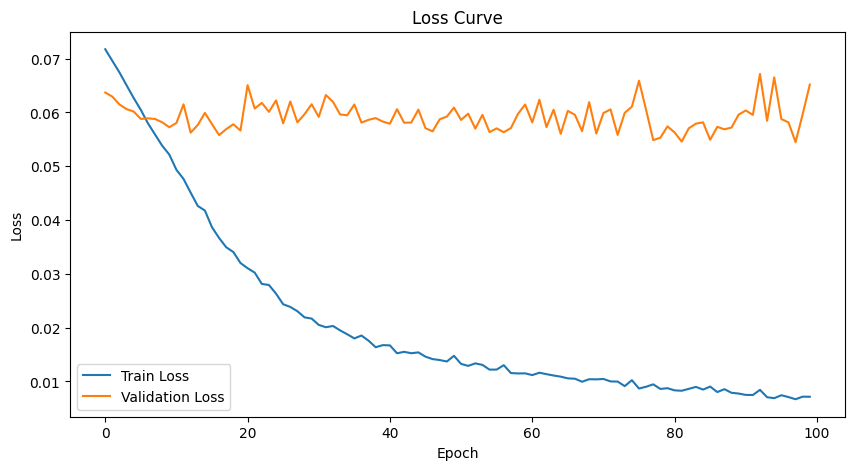

In [10]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()